In [1]:

import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))

from jaxutil import tetra_quad
from delaunay_rasterization.internal.alphablend_tiled_slang import render_alpha_blend_tiles_slang_raw, AlphaBlendTiledRender
from scipy.spatial import Voronoi, Delaunay

from delaunay_rasterization.internal.render_grid import RenderGrid
import delaunay_rasterization.internal.slang.slang_modules as slang_modules
from delaunay_rasterization.internal.tile_shader_slang import vertex_and_tile_shader

import numpy as np
import math
import torch
from torch import Tensor
from torch import nn

import matplotlib.pyplot as plt

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def printc(x, color):
    print(f"{color}{x}{bcolors.ENDC}")


def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

def get_slang_projection_matrix(znear, zfar, fy, fx, height, width, device):
    tanHalfFovX = width/(2*fx)
    tanHalfFovY = height/(2*fy)

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    z_sign = 1.0

    P = torch.tensor([
       [2.0 * znear / (right - left),     0.0,                          (right + left) / (right - left), 0.0 ],
       [0.0,                              2.0 * znear / (top - bottom), (top + bottom) / (top - bottom), 0.0 ],
       [0.0,                              0.0,                          z_sign * zfar / (zfar - znear),  -(zfar * znear) / (zfar - znear) ],
       [0.0,                              0.0,                          z_sign,                          0.0 ]
    ], device=device)

    return P

def common_camera_properties_from_gsplat(viewmats, Ks, height, width):
  """ Fetches all the Camera properties from the inria defined object"""
  zfar = 100.0
  znear = 0.01
  
  world_view_transform = viewmats
  fx = Ks[0,0]
  fy = Ks[1,1]
  projection_matrix = get_slang_projection_matrix(znear, zfar, fy, fx, height, width, Ks.device)
  fovx = focal2fov(fx, width)
  fovy = focal2fov(fy, height)

  cam_pos = viewmats.inverse()[:3, 3]

  return world_view_transform, projection_matrix, cam_pos, fovy, fovx



/home/amai/delaunay_rasterization


### Scene setup

In [2]:
height = 3
width = 3
tile_size = 16
fov = 60

f = height / math.tan(fov * math.pi / 180 / 2.0);
K = torch.tensor([
  [f, 0, width/2],
  [0, f, height/2],
  [0, 0, 1],
])

viewmat = torch.eye(4)
viewmat[2, 3] = 0.1

world_view_transform, projection_matrix, cam_pos, fovy, fovx = common_camera_properties_from_gsplat(viewmat, K, height, width)

In [3]:
num_freq = 5
net = nn.Sequential(
  nn.Linear(3*num_freq, 256),
  nn.ReLU(inplace=True),
  nn.Linear(256, 256),
  nn.ReLU(inplace=True),
  nn.Linear(256, 256),
  nn.ReLU(inplace=True),
  nn.Linear(256, 4),
).cuda()

torch.manual_seed(8)
N = 5
vertices = (torch.rand((N, 3)) * 2 - 1)*100

# data = torch.load("edge_cases/1.pth")
# vertices = data['vertices'].cpu().detach()[:100]
# net.load_state_dict(data['net'])

# vertices_np = vertices.numpy()
# v = Delaunay(vertices_np)
# indices = torch.as_tensor(v.simplices).cuda()

indices = torch.tensor([
  [0, 1, 2, 3]]).int().cuda()

vertices_np = vertices.numpy()
vertices = nn.Parameter(vertices.cuda())
print(vertices)



freq = 2**torch.arange(num_freq).cuda()
def safe_exp(x):
  return x.clip(max=5).exp()

def rgbs_fn(xyz):
  exyz = xyz.reshape(-1, 3, 1) * freq.reshape(1, -1).expand(1, 3, -1)
  exy = torch.cos(exyz.reshape(-1, 3 * num_freq))
  rgbs_raw = net(exy)
  rgbs = torch.cat([torch.sigmoid(10*rgbs_raw[:, :3]), safe_exp(rgbs_raw[:, 3:])], dim=1)
  return rgbs




Parameter containing:
tensor([[ 19.5855,  69.0592,  89.2821],
        [-40.6939,   2.7604,  28.8692],
        [ 79.8112, -97.1822,  15.6903],
        [-75.6386,  83.6187,  36.1066],
        [-59.9965, -77.5780, -99.6103]], device='cuda:0', requires_grad=True)


### Find circumcenters and get color

In [4]:
render_grid = RenderGrid(height,
                            width,
                            tile_height=tile_size,
                            tile_width=tile_size)
sorted_tetra_idx, tile_ranges, radii, vs_tetra, circumcenter = vertex_and_tile_shader(indices,
                                                                                vertices,
                                                                                world_view_transform.cuda(),
                                                                                projection_matrix.cuda(),
                                                                                cam_pos.cuda(),
                                                                                fovy,
                                                                                fovx,
                                                                                render_grid)

# retain_grad fails if called with torch.no_grad() under evaluation
try:
    vs_tetra.retain_grad()
except:
    pass
# ic(circumcenter)
rgbs = rgbs_fn(circumcenter)
rgbs = torch.rand_like(rgbs)


In [5]:
print(vs_tetra)

tensor([[  -2.2116,   -2.2173, -259.3794]], device='cuda:0',
       grad_fn=<VertexShaderBackward>)


### Render using jax

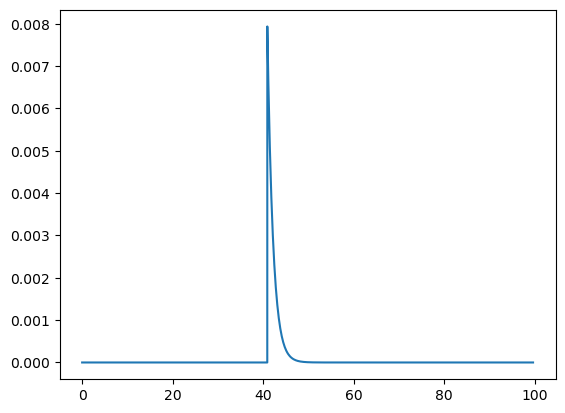

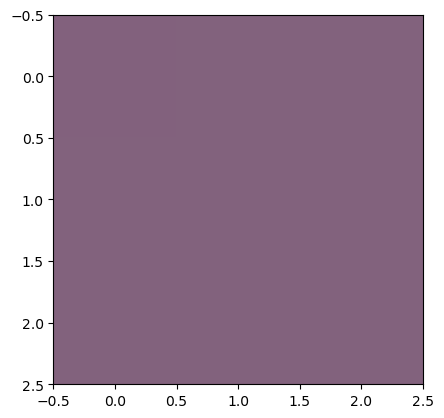

In [6]:
# get rays
def construct_camera_ray_torch(viewmatrix, cam_pos, pixel_x, pixel_y, W, H, focal_x, focal_y):
    V = viewmatrix[:3, :3].T
    
    # Construct ray direction in camera space
    ray_dir = torch.tensor([
        (pixel_x + 0.5 - W / 2.0) / focal_x,
        (pixel_y + 0.5 - H / 2.0) / focal_y,
        1.0
    ], device=cam_pos.device).float()
    
    # Normalize and transform by view matrix
    ray_dir = ray_dir / torch.norm(ray_dir)
    ray_dir = V @ ray_dir
    
    return cam_pos, ray_dir
i, j = 1, 1
tdist = np.linspace(0, vertices.abs().max().item(), 10000)
densities = rgbs[:, 3].detach().cpu().numpy()
colors = rgbs[:, :3].detach().cpu().numpy()
ray_origins = cam_pos.numpy().reshape(1, -1)
pixels_x, pixels_y = np.meshgrid(np.arange(height), np.arange(width))
fx = width / (2 * math.tan(fovx / 2))
fy = height / (2 * math.tan(fovy / 2))

im = np.zeros((height, width, 3))
for i in range(height):
    for j in range(width):
        _, ray_directions = construct_camera_ray_torch(world_view_transform, cam_pos, pixels_x[i, j], pixels_y[i, j], width, height, fx, fy)
        ray_directions = ray_directions.numpy()
        color, extras = tetra_quad.render_tetrahedra_volume(ray_origins, ray_directions, tdist,
                                    vertices_np, indices.cpu().numpy(), densities.reshape(-1, 1), colors, return_extras=True)
        im[i, j] = color[0, :3]
plt.plot(extras['tdist'][1:], extras['weights'][0])
plt.show()
plt.imshow(im)

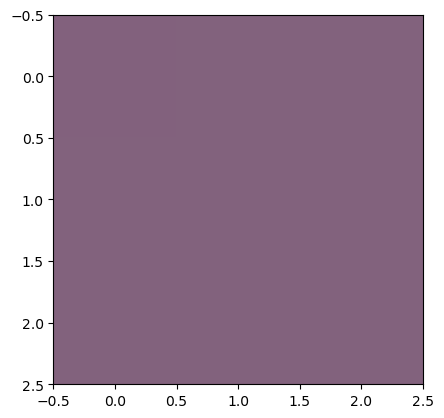

In [7]:


# print(vs_tetra)
image_rgb = AlphaBlendTiledRender.apply(
    sorted_tetra_idx,
    tile_ranges,
    indices,
    vertices,
    rgbs,
    render_grid,
    world_view_transform.cuda(),
    projection_matrix.cuda(),
    cam_pos.cuda(),
    fovy,
    fovx)
# print(image_rgb[i, j])
# print(image_rgb.min())
plt.imshow(image_rgb[:, :, :3].detach().cpu().numpy())
plt.show()

1.3079908159044053e-06
1.7881393432617188e-07 2.205371856689453e-06


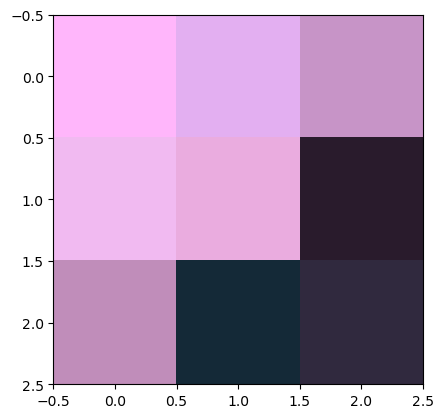

In [8]:
diff = (im - image_rgb[..., :3].cpu().detach().numpy())
print(np.abs(diff).mean())
print(diff.min(), diff.max())
plt.imshow(np.abs(diff) / np.abs(diff).max())
plt.show()